In [1]:
from signals import *
import pandas as pd
import numpy as np
from hyperopt import fmin, tpe, hp
from indicators.indicator.indicators import SMA, SuperTrend
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def meta_super_trend(df, sample_mins, period, multiplier):

    ohlc_dict = {'Open':'first', 'High':'max', 'Low':'min', 'Close': 'last'}
    base_interval = (df.index[1]-df.index[0]).components.minutes
    dfs = []
    for base in range(0, sample_mins, base_interval):
        tmp = df.resample(f"{sample_mins}Min", base=base).apply(ohlc_dict).dropna()
        SuperTrend(tmp, period, multiplier, prefix=sample_mins)
        dfs.append(tmp)

    return pd.concat(dfs).sort_index()

### Pure Supertrend Signals

In [85]:
# Single Supertrend signal
def supertrend_signals(ticker, frequency, multiplier, period, take_profit, stop_loss, verbose=False):
    fees = 2.5 # pips
    period = int(period)
    multiplier = int(multiplier)
    risk = 0.02
    balance = 1000
    potential_loss = risk * balance
    pounds_per_pip = potential_loss / (stop_loss + fees)
    
    trend_col_name = 'STX_' + str(period) + '_' + str(multiplier)

    ST = 0
    last_ST = 0
    signal = 0
    
    stance = 0
    
    take_profit_price = None
    stop_loss_price = None
    entry = None
    profit_pips = 0.0
    win = 0
    loss = 0
    profits = []

    df = load_ticker(ticker, frequency)
    #df = meta_super_trend(df, signal_frequency, period, multiplier)
    SuperTrend(df, period, multiplier)


    for dt, row in df.iterrows():
        signal = 0
        if row[trend_col_name] > 0:
            ST = 1
        elif row[trend_col_name] < 0:
            ST = -1
            
        if ST > last_ST:
            signal = 1
        if ST < last_ST:
            signal = -1
            
        last_ST = ST
        
        def close_buy(exit_price):
            nonlocal profit_pips, profits, entry, win, loss, balance
            if entry is None:
                return
            trade_profit = (exit_price - entry) * pip_factor(ticker) - fees
            profit_pips += trade_profit
            profits.append(trade_profit)
            
            pounds_per_pip = risk * balance / (stop_loss + fees)
            balance += pounds_per_pip * trade_profit
            
            entry = None

            if trade_profit > 0:
                win += 1
            else:
                loss += 1
                
            if verbose:
                print(f"{dt}: Close Buy: profit = {trade_profit}, Lots = {pounds_per_pip/10}")
            
        def close_sell(exit_price):
            nonlocal profit_pips, profits, entry, win, loss, balance
            if entry is None:
                return
            trade_profit = (entry - exit_price) * pip_factor(ticker) - fees
            profit_pips += trade_profit
            profits.append(trade_profit)
            
            pounds_per_pip = (risk * balance) / (stop_loss + fees)
            balance += pounds_per_pip * trade_profit
            
            entry = None

            if trade_profit > 0:
                win += 1
            else:
                loss += 1
                        
            if verbose:
                print(f"{dt}: Close Sell: profit = {trade_profit}, Lots = {pounds_per_pip/10}")
                        
        #potential_exit = row.Close
        
        #if entry is not None and take_profit_price is not None and stop_loss_price is not None:
        if stance > 0:
            if row.High > take_profit_price:
                stance = 0
                #print("Take Profit hit")
                close_buy(take_profit_price)
                    
            if row.Low < stop_loss_price:
                stance = 0
                #print("Stop Loss hit")
                close_buy(stop_loss_price)

        elif stance < 0:
            if row.Low < take_profit_price:
                stance = 0
                #print(f"Take Profit hit {entry}")
                close_sell(take_profit_price)

            if row.High > stop_loss_price:
                stance = 0
                #print("Stop Loss hit")
                close_sell(stop_loss_price)
            
        if signal != 0 and stance != signal:
            # signal = 1 (Buy)
            # stance = -1, 0
            if signal == 1:
                if stance == -1:
                    close_sell(row.Close)
                entry = row.Close
                take_profit_price = entry + (take_profit/pip_factor(ticker))
                stop_loss_price = entry - (stop_loss/pip_factor(ticker))
                stance = 1
                #print(f"Open Buy: entry = {entry}, tp = {take_profit_price}")

            if signal == -1:
                if stance == 1:
                    close_buy(row.Close)
                entry = row.Close
                take_profit_price = entry - (take_profit/pip_factor(ticker))
                stop_loss_price = entry + (stop_loss/pip_factor(ticker))
                stance = -1
                #print(f"Open Sell: entry = {entry}, tp = {take_profit_price}")

                    
    if verbose:
        print(f"{win + loss} Trades, Win Ratio = {1.*win/(win+loss):.2}")
        plt.hist(profits, bins=20)
    #return -profit_pips
    return -balance
    #return -profit_pips / stop_loss # Minimise stop loss
    #return -np.mean(profits)/np.std(profits) # Sharpe Ratio
    #return -1.*win/(win+loss)    

ticker = "EURUSD"
print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=63, 
                          take_profit=123, stop_loss=21, verbose=False))
# Balance 5705, 5% risk
# print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=63, take_profit=123, stop_loss=21, verbose=False))

#Profit (30 mins) 2019
#print(-supertrend_signals(ticker, frequency=30, multiplier=8, period=110, take_profit=120, stop_loss=70, verbose=True))

# Profit (60 mins) 2081
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=54, take_profit=123, stop_loss=75, verbose=True))

# Sharpe Ratio (0.69) 1416
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=53, take_profit=47, stop_loss=199, verbose=True))

# Stop loss reduced profit 849
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=54, take_profit=72, stop_loss=28, verbose=True))

2208.4239167233804


### Coarse Search

In [86]:
def objective(params):
    return supertrend_signals(**params)

space = {'ticker': hp.choice('ticker', ["USDJPY"]),
         'frequency': hp.choice('frequency', [60]),
         'multiplier': hp.quniform('multiplier', 3, 7, 1),
         'period': hp.quniform('period', 10, 200, 1),
         'take_profit': hp.quniform('take_profit', 10, 200, 1),
         'stop_loss': hp.quniform('stop_loss', 10, 200, 1),
        }

for _ in range(1):
    print(fmin(objective, space, algo=tpe.suggest, max_evals=256))

    

100%|██████████| 256/256 [7:54:49<00:00, 111.29s/trial, best loss: -1730.2804081949969]     
{'frequency': 0, 'multiplier': 7.0, 'period': 76.0, 'stop_loss': 14.0, 'take_profit': 65.0, 'ticker': 0}


### Finetuning

In [9]:
def objective(params):
    return supertrend_signals(**params)

space = {'ticker': hp.choice('ticker', ["EURUSD"]),
         'frequency': hp.choice('frequency', [60]),
         'multiplier': hp.qnormal('multiplier', 5, 5, 1),
         'period': hp.qnormal('period', 54, 10, 1),
         'take_profit': hp.qnormal('take_profit', 123, 20, 1),
         'stop_loss': hp.qnormal('stop_loss', 75, 20, 1),
        }

for _ in range(1):
    print(fmin(objective, space, algo=tpe.suggest, max_evals=100))

    

100%|██████████| 100/100 [02:22<00:00,  1.43s/trial, best loss: -1903.9999999999923]
{'frequency': 0, 'multiplier': 5.0, 'period': 65.0, 'stop_loss': 150.0, 'take_profit': 127.0, 'ticker': 0}


### Supertrend SMA

2019-01-28 05:00:00: Close Sell: profit = -28.499999999999357
2019-02-01 07:00:00: Close Buy: profit = 31.500000000000696
2019-02-08 16:00:00: Close Sell: profit = 120.49999999999977
2019-02-13 21:00:00: Close Buy: profit = -72.49999999999895
2019-02-18 07:00:00: Close Sell: profit = -34.50000000000092
2019-03-01 07:00:00: Close Buy: profit = 66.49999999999906
2019-03-07 14:00:00: Close Sell: profit = 120.49999999999977
2019-03-18 11:00:00: Close Buy: profit = 120.49999999999977
2019-03-27 07:00:00: Close Sell: profit = 120.49999999999977
2019-04-18 23:00:00: Close Buy: profit = 1.4999999999995595
2019-04-26 13:00:00: Close Sell: profit = 120.49999999999977
2019-05-02 04:00:00: Close Buy: profit = 26.500000000001247
2019-05-05 22:00:00: Close Sell: profit = 24.500000000001467
2019-05-15 02:00:00: Close Buy: profit = 25.500000000001357
2019-05-24 02:00:00: Close Sell: profit = 23.499999999999357
2019-05-29 00:00:00: Close Buy: profit = -15.500000000000789
2019-06-03 06:00:00: Close Sell

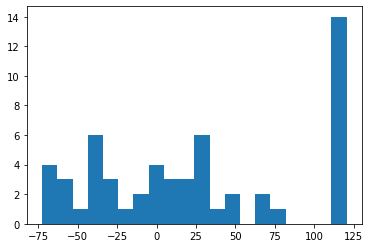

In [43]:
# Single Supertrend signal
def supertrend_signals_sma(ticker, frequency, multiplier, period, sma_period, take_profit, stop_loss, verbose=False):
    fees = 2.5 # pips
    period = int(period)
    multiplier = int(multiplier)
    sma_period = int(sma_period)
    
    trend_col_name = 'STX_' + str(period) + '_' + str(multiplier)

    ST = 0
    last_ST = 0
    signal = 0
    
    stance = 0
    
    take_profit_price = None
    stop_loss_price = None
    entry = None
    profit_pips = 0.0
    win = 0
    loss = 0
    profits = []

    df = load_ticker(ticker, frequency)
    #df = meta_super_trend(df, signal_frequency, period, multiplier)
    SuperTrend(df, period, multiplier)
    sma_name = f"SMA_{sma_period}"
    SMA(df, "Close", sma_name, sma_period)


    for dt, row in df.iterrows():
        signal = 0
        if row[trend_col_name] > 0 and row[sma_name] > row.Close:
            ST = 1
        elif row[trend_col_name] < 0  and row[sma_name] < row.Close:
            ST = -1
            
        if ST > last_ST:
            signal = 1
        if ST < last_ST:
            signal = -1
            
        last_ST = ST
        
        def close_buy(exit_price):
            nonlocal profit_pips, profits, entry, win, loss
            if entry is None:
                return
            trade_profit = (exit_price - entry) * pip_factor(ticker) - fees
            profit_pips += trade_profit
            profits.append(trade_profit)
            entry = None

            if trade_profit > 0:
                win += 1
            else:
                loss += 1
                
            if verbose:
                print(f"{dt}: Close Buy: profit = {trade_profit}")
            
        def close_sell(exit_price):
            nonlocal profit_pips, profits, entry, win, loss
            if entry is None:
                return
            trade_profit = (entry - exit_price) * pip_factor(ticker) - fees
            profit_pips += trade_profit
            profits.append(trade_profit)
            entry = None

            if trade_profit > 0:
                win += 1
            else:
                loss += 1
                        
            if verbose:
                print(f"{dt}: Close Sell: profit = {trade_profit}")
                        
        #potential_exit = row.Close
        
        #if entry is not None and take_profit_price is not None and stop_loss_price is not None:
        if stance > 0:
            if row.High > take_profit_price:
                stance = 0
                #print("Take Profit hit")
                close_buy(take_profit_price)
                    
            if row.Low < stop_loss_price:
                stance = 0
                #print("Stop Loss hit")
                close_buy(stop_loss_price)

        elif stance < 0:
            if row.Low < take_profit_price:
                stance = 0
                #print(f"Take Profit hit {entry}")
                close_sell(take_profit_price)

            if row.High > stop_loss_price:
                stance = 0
                #print("Stop Loss hit")
                close_sell(stop_loss_price)
            
        if signal != 0 and stance != signal:
            # signal = 1 (Buy)
            # stance = -1, 0
            if signal == 1:
                if stance == -1:
                    close_sell(row.Close)
                entry = row.Close
                take_profit_price = entry + (take_profit/pip_factor(ticker))
                stop_loss_price = entry - (stop_loss/pip_factor(ticker))
                stance = 1
                #print(f"Open Buy: entry = {entry}, tp = {take_profit_price}")

            if signal == -1:
                if stance == 1:
                    close_buy(row.Close)
                entry = row.Close
                take_profit_price = entry - (take_profit/pip_factor(ticker))
                stop_loss_price = entry + (stop_loss/pip_factor(ticker))
                stance = -1
                #print(f"Open Sell: entry = {entry}, tp = {take_profit_price}")

                    
    if verbose:
        print(f"{win + loss} Trades, Win Ratio = {1.*win/(win+loss):.2}")
        plt.hist(profits, bins=20)
    return -profit_pips
    #return -profit_pips / stop_loss # Minimise stop loss
    #return -np.mean(profits)/np.std(profits) # Sharpe Ratio
    #return -1.*win/(win+loss)    

ticker = "EURUSD"
print(-supertrend_signals_sma(ticker, frequency=60, multiplier=5, period=53, sma_period=10,
                          take_profit=123, stop_loss=70, verbose=True))
#Profit (30 mins) 2019
#print(-supertrend_signals(ticker, frequency=30, multiplier=8, period=110, take_profit=120, stop_loss=70, verbose=True))

# Profit (60 mins) 2081
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=54, take_profit=123, stop_loss=75, verbose=True))

# Sharpe Ratio (0.69) 1416
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=53, take_profit=47, stop_loss=199, verbose=True))

# Stop loss reduced profit 849
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=54, take_profit=72, stop_loss=28, verbose=True))

In [45]:
def objective(params):
    return supertrend_signals_sma(**params)

space = {'ticker': hp.choice('ticker', ["EURUSD"]),
         'frequency': hp.choice('frequency', [60]),
         'multiplier': hp.quniform('multiplier', 1, 20, 1),
         'period': hp.quniform('period', 10, 200, 1),
         'sma_period': hp.quniform('sma_period', 10, 200, 1),
         'take_profit': hp.quniform('take_profit', 10, 200, 1),
         'stop_loss': hp.quniform('stop_loss', 10, 200, 1),
        }

for _ in range(1):
    print(fmin(objective, space, algo=tpe.suggest, max_evals=100))

    

100%|██████████| 100/100 [02:45<00:00,  1.65s/trial, best loss: -1085.499999999988]
{'frequency': 0, 'multiplier': 4.0, 'period': 81.0, 'sma_period': 13.0, 'stop_loss': 125.0, 'take_profit': 85.0, 'ticker': 0}


## Double supertrend 

In [ ]:
def supertrend_signals_open_close(ticker, frequency, open_multiplier, open_period, close_multiplier, close_period, take_profit, stop_loss, verbose=False):
    fees = 2.5 # pips
    open_period = int(open_period)
    open_multiplier = int(open_multiplier)
    close_period = int(close_period)
    close_multiplier = int(close_multiplier)
    
    open_trend_col_name = 'STX_' + str(open_period) + '_' + str(open_multiplier)
    close_trend_col_name = 'STX_' + str(close_period) + '_' + str(close_multiplier)
    close_value_col_name = 'ST_' + str(close_period) + '_' + str(close_multiplier)

    ST = 0
    last_ST = 0
    last_close = None
    last_close_stance = 0
    signal = 0
    
    stance = 0
    
    take_profit_price = None
    stop_loss_price = None
    entry = None
    profit_pips = 0.0
    win = 0
    loss = 0
    profits = []

    df = load_ticker(ticker, frequency)
    
    SuperTrend(df, open_period, open_multiplier)
    SuperTrend(df, close_period, close_multiplier)


    for dt, row in df.iterrows():
        signal = 0
        if row[open_trend_col_name] > 0:
            ST = 1
        elif row[open_trend_col_name] < 0:
            ST = -1
            
        if ST > last_ST:
            signal = 1
        if ST < last_ST:
            signal = -1
            
        last_ST = ST
        
        def close_buy(exit_price):
            nonlocal profit_pips, profits, entry, win, loss
            if entry is None:
                return
            trade_profit = (exit_price - entry) * pip_factor(ticker) - fees
            profit_pips += trade_profit
            profits.append(trade_profit)
            entry = None

            if trade_profit > 0:
                win += 1
            else:
                loss += 1
                
            if verbose:
                print(f"Close Buy: profit = {trade_profit}")
            
        def close_sell(exit_price):
            nonlocal profit_pips, profits, entry, win, loss
            if entry is None:
                return
            trade_profit = (entry - exit_price) * pip_factor(ticker) - fees
            profit_pips += trade_profit
            profits.append(trade_profit)
            entry = None

            if trade_profit > 0:
                win += 1
            else:
                loss += 1
                        
            if verbose:
                print(f"Close Sell: profit = {trade_profit}")
                        
        if stance > 0:
            if last_close_stance != stance:
                close_buy(row.Close)
                    
            if row.High > take_profit_price:
                stance = 0
                #print("Take Profit hit")
                close_buy(take_profit_price)
                    
            if row.Low < stop_loss_price:
                stance = 0
                #print("Stop Loss hit")
                close_buy(stop_loss_price)

        elif stance < 0:
            if last_close_stance != stance:
                close_sell(row.Close)
                    
            elif row.Low < take_profit_price:
                stance = 0
                #print(f"Take Profit hit {entry}")
                close_sell(take_profit_price)

            elif row.High > stop_loss_price:
                stance = 0
                #print("Stop Loss hit")
                close_sell(stop_loss_price)
            
        if signal != 0 and stance != signal:
            # signal = 1 (Buy)
            # stance = -1, 0
            if signal == 1:
                if stance == -1:
                    close_sell(row.Close)
                entry = row.Close
                take_profit_price = entry + (take_profit/pip_factor(ticker))
                stop_loss_price = entry - (stop_loss/pip_factor(ticker))
                stance = 1
                #print(f"Open Buy: entry = {entry}, tp = {take_profit_price}")

            if signal == -1:
                if stance == 1:
                    close_buy(row.Close)
                entry = row.Close
                take_profit_price = entry - (take_profit/pip_factor(ticker))
                stop_loss_price = entry + (stop_loss/pip_factor(ticker))
                stance = -1
                #print(f"Open Sell: entry = {entry}, tp = {take_profit_price}")
                
        last_close = row[close_value_col_name]
        last_close_stance = row[close_trend_col_name]

                    
    if verbose:
        print(f"{win + loss} Trades, Win Ratio = {1.*win/(win+loss):.2}")
        plt.hist(profits, bins=20)
    return -profit_pips
    #return -profit_pips / stop_loss # Minimise stop loss
    #return -np.mean(profits)/np.std(profits) # Sharpe Ratio
    #return -1.*win/(win+loss)    

ticker = "EURUSD"
print(-supertrend_signals_open_close(ticker, frequency=60, open_multiplier=5, open_period=54, 
                          close_multiplier=5, close_period=54,
                          take_profit=123, stop_loss=75, verbose=True))
#Profit (30 mins) 2019
#print(-supertrend_signals(ticker, frequency=30, multiplier=8, period=110, take_profit=120, stop_loss=70, verbose=True))

# Profit (60 mins) 2081
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=54, take_profit=123, stop_loss=75, verbose=True))

# Sharpe Ratio (0.69) 1416
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=53, take_profit=47, stop_loss=199, verbose=True))

# Stop loss reduced profit 849
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=54, take_profit=72, stop_loss=28, verbose=True))

In [ ]:
def objective(params):
    return supertrend_signals_open_close(**params)

space = {'ticker': hp.choice('ticker', ["EURUSD"]),
         'frequency': hp.choice('frequency', [60*24]),
         'open_multiplier': hp.quniform('open_multiplier', 1, 20, 1),
         'open_period': hp.quniform('open_period', 10, 200, 10),
         'close_multiplier': hp.quniform('close_multiplier', 1, 20, 1),
         'close_period': hp.quniform('close_period', 10, 200, 10),
         'take_profit': hp.quniform('take_profit', 10, 200, 10),
         'stop_loss': hp.quniform('stop_loss', 10, 200, 10),
        }

for _ in range(1):
    print(fmin(objective, space, algo=tpe.suggest, max_evals=1000))

    

### Supertrend and double moving average crossover

In [36]:

ticker = "EURUSD"

def supertrend_sma_signals(ticker, frequency, multiplier, period, sma_period):
    fees = 2.5 # pips
    period = int(period)
    multiplier = int(multiplier)
    sma_period = int(sma_period)

    

    last_val = 0.0
    entry = None
    profit_pips = 0.0
    
    df = load_ticker(ticker, frequency)
    SuperTrend(df, period, multiplier)
    
    trend_col_name = 'STX_' + str(period) + '_' + str(multiplier)
    sma_name = f"SMA_{sma_period}"
    df = SMA(df, "Close", sma_name, sma_period)


    for dt, row in df.iterrows():
        stance = 0
        if row[trend_col_name] > 0 and row.Close > row[sma_name]:
            stance = 1
        elif row[trend_col_name] < 0 and row.Close < row[sma_name]:
            stance = -1
            
        if stance != last_val:
            # Stance has changed
            if stance > last_val:
                # Sell to neutral
                # Sell to buy
                # Neutral to buy
                if last_val < 0.0 and entry is not None:
                    # Sell to something
                    # Exit the sell
                    profit_pips += (entry - row.Close) * pip_factor(ticker) - fees
                if stance > 0.0:
                    # Something to buy
                    # Take a long position
                    entry = row.Close
                
            if stance < last_val:
                if last_val > 0.0 and entry is not None:
                    profit_pips += (row.Close - entry) * pip_factor(ticker) - fees
                    
                if stance < 0.0:
                    entry = row.Close
        last_val = stance
    return -profit_pips    

print(-supertrend_sma_signals(ticker, 60, 50, 5, 100))

-222.5000000000116


In [37]:
def objective(params):
    return supertrend_sma_signals(**params)

space = {'ticker': hp.choice('ticker', ["EURUSD"]),
         'frequency': hp.choice('frequency', [60]),
         'multiplier': hp.quniform('multiplier', 1, 20, 1),
         'period': hp.quniform('period', 1, 100, 1),
         'sma_period': hp.quniform('sma_period', 20, 200, 10),
        }

for _ in range(1):
    print(fmin(objective, space, algo=tpe.suggest, max_evals=100))

    

100%|██████████| 100/100 [02:26<00:00,  1.46s/trial, best loss: -707.5000000000175]
{'frequency': 0, 'multiplier': 5.0, 'period': 52.0, 'sma_period': 140.0, 'ticker': 0}
